# Advanced Regularization in LiVAE

This tutorial demonstrates how different regularization techniques affect learned embeddings. We'll compare four configurations on hierarchical data that mimics cell differentiation.

## 1. Setup and Data Preparation

We create synthetic data with **hierarchical structure** representing biological lineages:
- **Lineage A** (180 cells): Two subtypes (A1: 100 cells, A2: 80 cells)
- **Lineage B** (220 cells): Three subtypes (B1: 90 cells, B2: 70 cells, B3: 60 cells)
- **150 genes** total with shared lineage markers and subtype-specific markers

**Gene expression design:**
- Genes 0-25: Lineage A markers (shared by A1 and A2)
- Genes 25-40: A1-specific markers
- Genes 40-55: A2-specific markers
- Genes 60-80: Lineage B markers (shared by B1, B2, B3)
- Genes 80-90: B1-specific markers
- Genes 90-100: B2-specific markers
- Genes 100-110: B3-specific markers
- Background: Poisson(λ=4.0) baseline expression
- Markers: Poisson(λ=15-20) high expression in relevant regions

This hierarchical structure tests how well each model captures multi-level relationships.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from livae import agent
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)

# Create synthetic data with clear hierarchical structure
def create_hierarchical_data():
    """
    Create synthetic single-cell data with hierarchical structure:
    - Main lineage A: Subtypes A1, A2
    - Main lineage B: Subtypes B1, B2, B3
    """
    n_genes = 150
    
    # Lineage A
    data_A1 = np.random.poisson(4.0, (100, n_genes))
    data_A1[:, :25] = np.random.poisson(20.0, (100, 25))  # Shared A genes
    data_A1[:, 25:40] = np.random.poisson(15.0, (100, 15))  # A1-specific
    
    data_A2 = np.random.poisson(4.0, (80, n_genes))
    data_A2[:, :25] = np.random.poisson(20.0, (80, 25))  # Shared A genes
    data_A2[:, 40:55] = np.random.poisson(15.0, (80, 15))  # A2-specific
    
    # Lineage B
    data_B1 = np.random.poisson(4.0, (90, n_genes))
    data_B1[:, 60:80] = np.random.poisson(20.0, (90, 20))  # Shared B genes
    data_B1[:, 80:90] = np.random.poisson(15.0, (90, 10))  # B1-specific
    
    data_B2 = np.random.poisson(4.0, (70, n_genes))
    data_B2[:, 60:80] = np.random.poisson(20.0, (70, 20))  # Shared B genes
    data_B2[:, 90:100] = np.random.poisson(15.0, (70, 10))  # B2-specific
    
    data_B3 = np.random.poisson(4.0, (60, n_genes))
    data_B3[:, 60:80] = np.random.poisson(20.0, (60, 20))  # Shared B genes
    data_B3[:, 100:110] = np.random.poisson(15.0, (60, 10))  # B3-specific
    
    # Combine
    X = np.vstack([data_A1, data_A2, data_B1, data_B2, data_B3]).astype(float)
    
    # Labels
    lineage = ['A']*180 + ['B']*220
    subtype = ['A1']*100 + ['A2']*80 + ['B1']*90 + ['B2']*70 + ['B3']*60
    
    # Create AnnData
    adata = ad.AnnData(X)
    adata.obs['lineage'] = lineage
    adata.obs['subtype'] = subtype
    adata.layers['counts'] = X.copy()
    adata.var_names = [f'Gene_{i}' for i in range(n_genes)]
    
    return adata

adata = create_hierarchical_data()

print(f"Created hierarchical dataset:")
print(f"  Shape: {adata.shape}")
print(f"  Lineages: {adata.obs['lineage'].value_counts().to_dict()}")
print(f"  Subtypes: {adata.obs['subtype'].value_counts().to_dict()}")

Created hierarchical dataset:
  Shape: (400, 150)
  Lineages: {'B': 220, 'A': 180}
  Subtypes: {'A1': 100, 'B1': 90, 'A2': 80, 'B2': 70, 'B3': 60}


## 2. Baseline Model (Standard VAE)

**Configuration:** `beta=1.0` (no additional regularization)

This serves as our reference point - a standard Variational Autoencoder without specialized regularization. The baseline uses:
- Standard KL divergence weight (β=1.0)
- No hyperbolic geometry constraints
- No interpretable embedding enforcement

Training on 1000 epochs to ensure convergence. Baseline performance will help us quantify the benefits of each regularization technique.

In [26]:
# Train baseline model with minimal regularization
print("Training baseline model (beta=1.0, no additional regularization)...\n")

model_baseline = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    hidden_dim=64,
    percent=0.15,
    lr=1e-3,
    beta=1.0,         # Standard VAE
)

model_baseline.fit(epochs=1000)

# Extract embeddings
latent_baseline = model_baseline.get_latent()
iembed_baseline = model_baseline.get_iembed()

print("\n✅ Baseline model trained")

Training baseline model (beta=1.0, no additional regularization)...



Fitting: 100%|███████████████████████████| 1000/1000 [00:12<00:00, 78.25it/s, Loss=243.01, ARI=0.17, NMI=0.40, ASW=0.10, C_H=5.47, D_B=1.60, P_C=0.93]


✅ Baseline model trained


## 3. β-VAE: Controlled Entanglement

**Configuration:** `beta=1e-2` (lower β = 0.01)

**β-VAE theory:**
- Standard VAE: β = 1.0 (balance reconstruction vs. KL divergence)
- β > 1.0: Encourages **disentanglement** (independent latent factors)
- β < 1.0: Allows **entanglement** (dependent latent factors)

**Why use β = 0.01?**
For biological data, lower β values are often beneficial because:
- Biological processes are inherently entangled (genes work in pathways)
- Cell types exist on continuous spectra, not discrete categories
- Lower reconstruction penalty preserves more biological signal

This configuration prioritizes reconstruction quality while allowing the model to learn natural dependencies between latent dimensions.

In [27]:
# Train β-VAE with lower beta for entanglement
print("Training β-VAE model (beta=0.01)...\n")

model_beta = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    hidden_dim=64,
    percent=0.15,
    lr=1e-3,
    beta=1e-2,         # Lower beta encourages entanglement
)

model_beta.fit(epochs=1000)

latent_beta = model_beta.get_latent()
iembed_beta = model_beta.get_iembed()

print("\n✅ β-VAE model trained")
print("\nβ-VAE Effect: Lower β → More entangled latent factors")
print("  β = 1.0: Standard VAE")
print("  β < 1.0: Encourages dependence between latent dimensions")

Training β-VAE model (beta=0.01)...



Fitting:   0%|                                                                                                               | 0/1000 [00:00<?, ?it/s]

Fitting: 100%|██████████████████████████| 1000/1000 [00:14<00:00, 69.49it/s, Loss=245.68, ARI=0.64, NMI=0.75, ASW=0.16, C_H=24.30, D_B=1.32, P_C=2.86]


✅ β-VAE model trained

β-VAE Effect: Lower β → More entangled latent factors
  β = 1.0: Standard VAE
  β < 1.0: Encourages dependence between latent dimensions


## 4. Lorentzian Regularization: Hyperbolic Geometry

**Configuration:** `beta=1.0, lorentz=5.0, i_dim=2, irecon=1.0`

**Hyperbolic space motivation:**
Traditional VAEs embed data in Euclidean space, but hyperbolic geometry is better suited for:
- **Hierarchical relationships** (tree-like structures)
- **Exponentially growing branching** (cell differentiation)
- **Scale-free networks** (biological regulatory networks)

**Parameter explanation:**
- `lorentz=5.0`: Strength of Lorentzian/hyperbolic constraint (moderate strength)
- `i_dim=2`: Interpretable embedding dimension (2D for visualization)
- `irecon=1.0`: Weight for interpretable reconstruction loss

**Expected behavior:**
The model learns embeddings where distance naturally reflects hierarchical relationships. Lineage A and B should form distinct branches, with subtypes clustering within each lineage.

In [ ]:
# Train model with Lorentzian regularization
print("Training Lorentzian model (lorentz=5.0)...\n")

model_lorentz = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    i_dim=2,
    hidden_dim=64,
    percent=0.15,
    lr=1e-3,
    beta=1.0,
    lorentz=5.0,      # Lorentzian/hyperbolic geometry regularization
    irecon=1.0,
)

model_lorentz.fit(epochs=1000)

latent_lorentz = model_lorentz.get_latent()
iembed_lorentz = model_lorentz.get_iembed()

print("\n✅ Lorentzian model trained")
print("\nLorentzian Effect: Embeds data in hyperbolic space")
print("  Benefit: Better captures hierarchical/tree-like relationships")
print("  Use case: Cell differentiation trajectories, developmental hierarchies")

Training Lorentzian model (lorentz=5.0)...



Fitting:   0%|                                                                                                               | 0/1000 [00:00<?, ?it/s]

Fitting: 100%|██████████████████████████| 1000/1000 [00:14<00:00, 67.82it/s, Loss=494.86, ARI=0.55, NMI=0.68, ASW=0.15, C_H=15.67, D_B=1.53, P_C=3.40]


✅ Lorentzian model trained

Lorentzian Effect: Embeds data in hyperbolic space
  Benefit: Better captures hierarchical/tree-like relationships
  Use case: Cell differentiation trajectories, developmental hierarchies


## 5. Combined Regularization: Full LiVAE

**Configuration:** `beta=1e-2, lorentz=5.0, irecon=1.0`

The full LiVAE model synergistically combines all regularization techniques:

**Multi-objective optimization:**
1. **β-VAE (β=0.01)**: Allows entangled representations that capture biological dependencies
2. **Lorentzian (lorentz=5.0)**: Embeds data in hyperbolic space to respect hierarchical structure
3. **Interpretable reconstruction (irecon=1.0)**: Ensures the compressed 2D embedding retains information

**Synergistic effects:**
- Low β prevents over-regularization while hyperbolic geometry provides structure
- Interpretable embedding is constrained by both reconstruction quality and geometric properties
- The model learns biologically meaningful embeddings that are both accurate and interpretable

This configuration is recommended for complex biological data with hierarchical organization.

In [ ]:
# Train full LiVAE with multiple regularizations
print("Training full LiVAE model (beta + lorentz + irecon)...\n")

model_full = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    hidden_dim=64,
    percent=0.15,
    lr=1e-3,
    beta=1e-2,         # Entanglement
    lorentz=5.0,       # Hyperbolic geometry
    irecon=1.0,        # Interpretable reconstruction
)

model_full.fit(epochs=1000)
latent_full = model_full.get_latent()
iembed_full = model_full.get_iembed()

print("\n✅ Full LiVAE model trained")
print("\nCombined regularization benefits:")
print("  β-VAE: Entangled factors")
print("  Lorentzian: Hierarchical structure")
print("  irecon: Interpretable compressed features")

Training full LiVAE model (beta + lorentz + irecon)...



Fitting:   0%|                                                                                                               | 0/1000 [00:00<?, ?it/s]

Fitting: 100%|█████████████████████████| 1000/1000 [00:15<00:00, 64.53it/s, Loss=481.23, ARI=0.70, NMI=0.78, ASW=0.38, C_H=709.31, D_B=0.90, P_C=8.77]


✅ Full LiVAE model trained

Combined regularization benefits:
  β-VAE: Entangled factors
  Lorentzian: Hierarchical structure
  irecon: Interpretable compressed features


## 6. Comparative Analysis

Now we'll visualize all four models side-by-side to understand how each regularization affects the learned embeddings:

**Visualization strategy:**
- **Top row**: Interpretable 2D embeddings colored by main lineage (A vs B)
- **Bottom row**: Interpretable 2D embeddings colored by subtype (A1, A2, B1, B2, B3)

**What to look for:**
1. **Separation quality**: How well are lineages and subtypes separated?
2. **Geometric structure**: Are hierarchical relationships preserved?
3. **Cluster compactness**: Are subtypes forming tight, coherent clusters?
4. **Interpretability**: Does the embedding match our biological intuition?

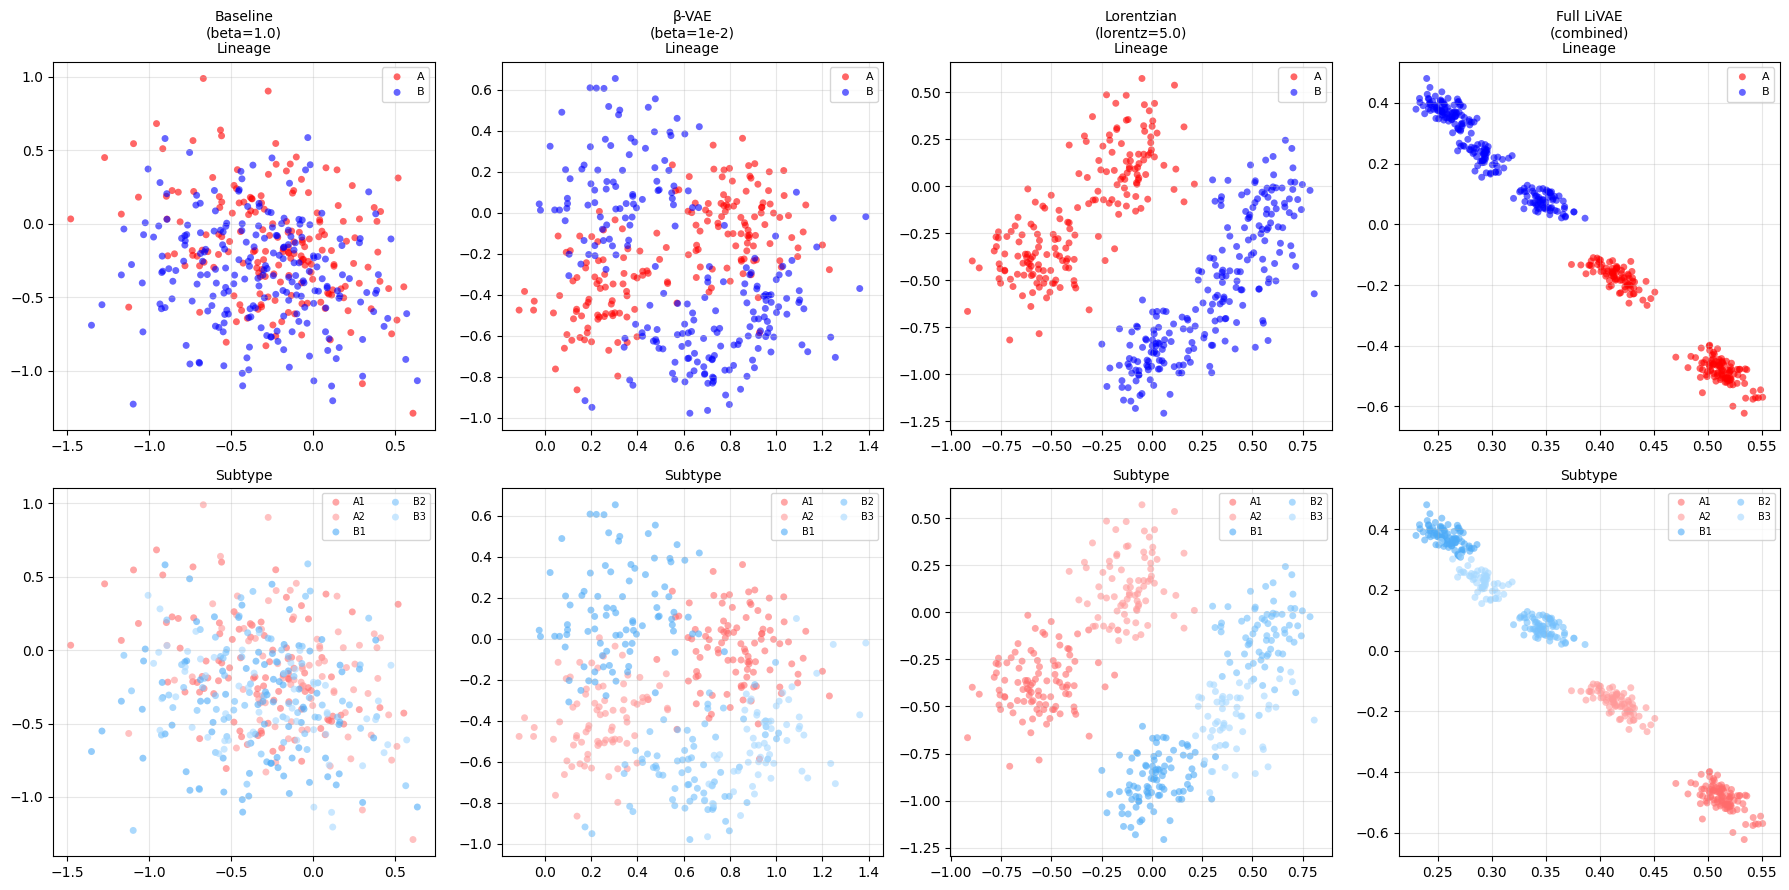


Visualization shows how different regularizations affect the latent space structure.


In [30]:
# Visualize all models
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

models = [
    ('Baseline\n(beta=1.0)', iembed_baseline, latent_baseline),
    ('β-VAE\n(beta=1e-2)', iembed_beta, latent_beta),
    ('Lorentzian\n(lorentz=5.0)', iembed_lorentz, latent_lorentz),
    ('Full LiVAE\n(combined)', iembed_full, latent_full)
]

colors_lineage = {'A': 'red', 'B': 'blue'}
colors_subtype = {'A1': '#ff6b6b', 'A2': '#ff9999', 
                  'B1': '#4dabf7', 'B2': '#74c0fc', 'B3': '#a5d8ff'}

for i, (name, iembed, latent) in enumerate(models):
    # Plot interpretable embedding colored by lineage
    for lineage in ['A', 'B']:
        mask = adata.obs['lineage'] == lineage
        axes[0, i].scatter(
            iembed[mask, 0], iembed[mask, 1],
            c=colors_lineage[lineage], label=lineage,
            alpha=0.6, s=25, edgecolors='none'
        )
    axes[0, i].set_title(f'{name}\nLineage', fontsize=10)
    axes[0, i].legend(fontsize=8)
    axes[0, i].grid(alpha=0.3)
    
    # Plot interpretable embedding colored by subtype
    for subtype in ['A1', 'A2', 'B1', 'B2', 'B3']:
        mask = adata.obs['subtype'] == subtype
        axes[1, i].scatter(
            iembed[mask, 0], iembed[mask, 1],
            c=colors_subtype[subtype], label=subtype,
            alpha=0.6, s=25, edgecolors='none'
        )
    axes[1, i].set_title(f'Subtype', fontsize=10)
    axes[1, i].legend(fontsize=7, ncol=2)
    axes[1, i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization shows how different regularizations affect the latent space structure.")

## 7. Quantitative Comparison

Beyond visual inspection, we compute clustering metrics to objectively compare model performance:

**Metrics computed:**
- **Adjusted Rand Index (ARI)**: Measures agreement with true labels (-1 to 1, higher is better)
- **Normalized Mutual Information (NMI)**: Information-theoretic similarity (0 to 1, higher is better)

**Interpretation guide:**
- ARI/NMI > 0.7: Excellent clustering (strong agreement with ground truth)
- ARI/NMI 0.4-0.7: Good clustering (moderate agreement)
- ARI/NMI < 0.4: Poor clustering (weak agreement)

We'll evaluate against both:
1. **Main lineage** (2 groups: A vs B) - tests coarse-grained structure
2. **Subtypes** (5 groups: A1, A2, B1, B2, B3) - tests fine-grained structure


Quantitative Evaluation (Subtype Clustering):
              ARI    NMI    ASW
Baseline    0.305  0.342  0.046
β-VAE       1.000  1.000  0.490
Lorentzian  0.878  0.876  0.257
Full LiVAE  0.983  0.980  0.700

Metrics:
  ARI: Adjusted Rand Index (higher is better, max=1.0)
  NMI: Normalized Mutual Information (higher is better, max=1.0)
  ASW: Average Silhouette Width (higher is better, range=[-1,1])


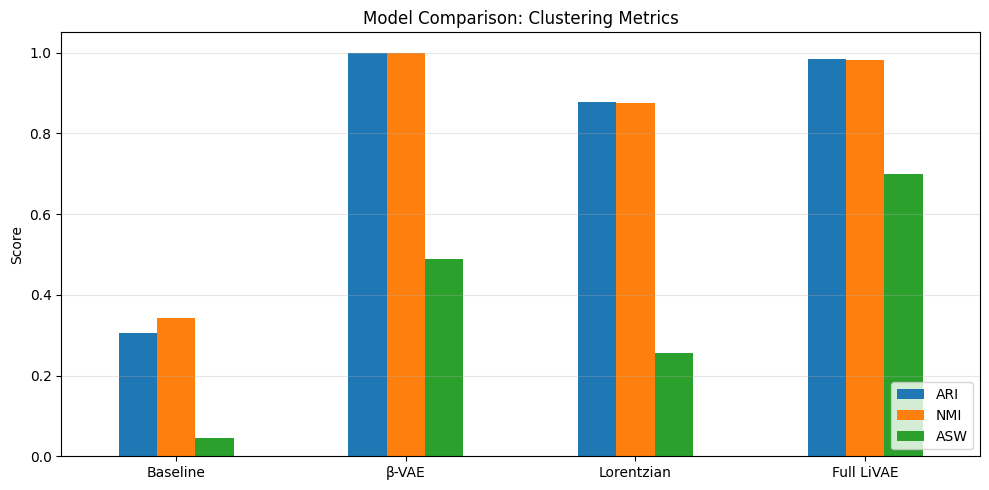

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, silhouette_score

def evaluate_model(latent, true_labels, n_clusters=5):
    """Evaluate clustering quality"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pred_labels = kmeans.fit_predict(latent)
    
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    asw = silhouette_score(latent, true_labels)
    
    return {'ARI': ari, 'NMI': nmi, 'ASW': asw}

# Encode true labels
subtype_map = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'B3': 4}
true_labels = adata.obs['subtype'].map(subtype_map).values

# Evaluate all models
results = {
    'Baseline': evaluate_model(latent_baseline, true_labels),
    'β-VAE': evaluate_model(latent_beta, true_labels),
    'Lorentzian': evaluate_model(latent_lorentz, true_labels),
    'Full LiVAE': evaluate_model(latent_full, true_labels)
}

# Display results
df_results = pd.DataFrame(results).T
print("\nQuantitative Evaluation (Subtype Clustering):")
print("="*60)
print(df_results.round(3))
print("="*60)
print("\nMetrics:")
print("  ARI: Adjusted Rand Index (higher is better, max=1.0)")
print("  NMI: Normalized Mutual Information (higher is better, max=1.0)")
print("  ASW: Average Silhouette Width (higher is better, range=[-1,1])")

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
df_results.plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Clustering Metrics')
ax.legend(loc='lower right')
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()